In [1]:
import tensorflow as tf
import tensorflow_addons as tfa
print(tf.__version__)
print(tfa.__version__)

from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras import backend as K

from tensorflow.keras.preprocessing import sequence
import numpy as np

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import gensim
from gensim.models.keyedvectors import KeyedVectors

plt.rcParams['font.sans-serif']=['simsun'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号

E:\download\anaconda\download\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.6.0 and strictly below 2.9.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.4.1 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


2.4.1
0.16.1


E:\download\anaconda\download\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


# w2v

In [2]:
w2v_path = "../../../TCM embedding/result/TCM_w2v.txt"

In [3]:
initial_vocab=[]
vocab_emb = {}
cnt = 0
for line in open(w2v_path,encoding='UTF-8'):
    if cnt != 0:
        char_ls = line.split()
        
        initial_vocab.append(char_ls[0])
        vocab_emb[char_ls[0]] = char_ls[1:]
    else:
        cnt += 1

In [4]:
len(vocab_emb) == len(initial_vocab)

True

In [5]:
#读取所有数据生成字典
def build_data(train_path,initial_vocab):
    datas = []#【【句子】，【对应标签】】
    #先加入特殊词
    vocabs = {'UNK'}
    #vocabs.add('PAD')
    
    data=[]
    cate=[]
    temp_data = []
    temp_cate = []
    for line in open(train_path,encoding='UTF-8'):
        if line == '\n' or line.split()[0] == "。":
            if len(temp_data)!= 0:
                data.append(temp_data)
                cate.append(temp_cate)
                temp_data = []
                temp_cate = []
        else:
            line_ls = line.split()
            char = line_ls[0].strip()
            label = line_ls[1].strip()
            temp_data.append(char)
            temp_cate.append(label)
            
    for item in range(0,len(data)):
        datas.append([data[item],cate[item]])
        for i in data[item]:#数据中的词加入词库
            vocabs.add(i)
    for i in initial_vocab:#w2v中的词加入词库
        vocabs.add(i)
    
    embeddings_matrix = np.zeros((len(vocabs), 200))# 初始化矩阵
    
    #索引和BIO标签对应
    label=set()
    for item in cate:
        for i in item:
            label.add(i)
    idx2label = {idx: label for idx, label in enumerate(list(label))}
    label2idx = {label: idx for idx,label  in idx2label.items()}
    
    #字符和索引编号对应
    idx2vocab = {idx: char for idx, char in enumerate(list(vocabs))}
    vocab2idx = {char: idx for idx, char in idx2vocab.items()}
    
    # 权重矩阵
    for i in idx2vocab:
        if idx2vocab[i] in initial_vocab:
            embeddings_matrix[i] = vocab_emb[idx2vocab[i]]
        
    #self.write_file(list(vocabs), self.vocab_path)
    return datas,label,idx2vocab,vocab2idx,idx2label,label2idx,embeddings_matrix

In [6]:
datas,label,idx2vocab,vocab2idx,idx2label,label2idx,embeddings_matrix = build_data('../../data/LAB1/corpus-buduan.txt',initial_vocab)

In [7]:
#读取所有数据生成字典
def load_data(train_path):
    datas = []#【【句子】，【对应标签】】

    
    data=[]
    cate=[]
    temp_data = []
    temp_cate = []
    for line in open(train_path,encoding='UTF-8'):
        if line == '\n' or line.split()[0] == "。":
            if len(temp_data)!= 0:
                data.append(temp_data)
                cate.append(temp_cate)
                temp_data = []
                temp_cate = []
        else:
            line_ls = line.split()
            char = line_ls[0].strip()
            label = line_ls[1].strip()
            temp_data.append(char)
            temp_cate.append(label)
            
    for item in range(0,len(data)):
        datas.append([data[item],cate[item]])
    
    return datas

In [8]:
train = load_data('../../data/LAB1/train-buduan.txt')
test = load_data('../../data/LAB1/test-buduan.txt')
dev = load_data('../../data/LAB1/dev-buduan.txt')

In [9]:
train.extend(dev)

In [10]:
#按照索引建立训练数据
def read_corpus(datas,vocab2idx,label2idx):
    corpus, labels = [],[]
    for item in datas:
        sent_=item[0]
        tag_=item[1]
        sent_ids = [vocab2idx[char] if char in vocab2idx else vocab2idx['<UNK>'] for char in sent_]
        tag_ids = [label2idx[label] if label in label2idx else 0 for label in tag_]
        corpus.append(sent_ids)
        labels.append(tag_ids)
    return corpus,labels

In [11]:
X_train,y_train = read_corpus(train,vocab2idx,label2idx)
X_test,y_test = read_corpus(test,vocab2idx,label2idx)

In [12]:
len(X_train)

555

In [13]:
len(X_test)

144

# 模型

In [14]:
length = [len(i) for i in X_train]

(array([128., 187., 120.,  68.,  26.,  11.,   3.,   2.,   7.,   3.]),
 array([  1.,  11.,  21.,  31.,  41.,  51.,  61.,  71.,  81.,  91., 101.]),
 <BarContainer object of 10 artists>)

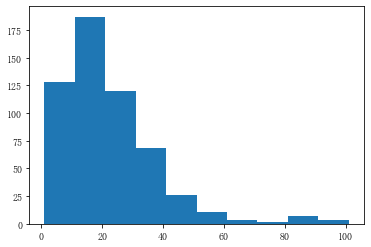

In [15]:
import matplotlib.pyplot as plt

plt.hist(length)

In [16]:
max_len = 100

In [17]:
class CRF(layers.Layer):
    def __init__(self, label_size):
        super(CRF, self).__init__()
        #随机生成0，1范围内shape × shape的矩阵
        self.trans_params = tf.Variable(
            tf.random.uniform(shape=(label_size, label_size)), name="transition")
    #实现 Graph Execution
    @tf.function
    def call(self, inputs, labels, seq_lens):#使用crf来计算损失
        #inputs: 一个形状为[batch_size, max_seq_len, num_tags] 的tensor,一般使用BILSTM处理之后输出转换为他要求的形状作为CRF层的输入
        #labels：形状为[batch_size, max_seq_len]的矩阵，真实标签
        #seq_lens：一个形状为 [batch_size] 的向量,表示每个序列的长度
        #transition_params：转移矩阵
        log_likelihood, self.trans_params = tfa.text.crf_log_likelihood(
                                                inputs, labels, seq_lens,
                                                transition_params=self.trans_params)
        #损失
        loss = tf.reduce_sum(-log_likelihood)
        return loss

In [18]:
K.clear_session()

EPOCHS = 16
BATCH_SIZE = 64
EMBED_DIM = 200#词向量的维度
HIDDEN_SIZE = 200#隐层状态的维数
MAX_LEN = 100
VOCAB_SIZE = len(vocab2idx)
CLASS_NUMS = len(label2idx)

inputs = layers.Input(shape=(MAX_LEN,), name='input_ids', dtype='int32')
targets = layers.Input(shape=(MAX_LEN,), name='target_ids', dtype='int32')
seq_lens = layers.Input(shape=(), name='input_lens', dtype='int32')

#嵌入层 词汇表的大小；词向量的维度
x = layers.Embedding(input_dim=VOCAB_SIZE, output_dim=EMBED_DIM,weights = [embeddings_matrix])(inputs)
x = layers.Bidirectional(layers.LSTM(HIDDEN_SIZE, return_sequences=True))(x)
logits = layers.Dense(CLASS_NUMS)(x)#全连接层 CLASS_NUMS：输出的单元个数，output_shape = (batch_size ,units),输入的形状input_shape =(batch_size,input_dim)
loss = CRF(label_size=CLASS_NUMS)(logits, targets, seq_lens)

model = models.Model(inputs=[inputs, targets, seq_lens], outputs=loss)

print(model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 100)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 100, 200)     12807600    input_ids[0][0]                  
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 100, 400)     641600      embedding[0][0]                  
__________________________________________________________________________________________________
dense (Dense)                   (None, 100, 16)      6416        bidirectional[0][0]              
______________________________________________________________________________________________

In [19]:
from keras.utils import plot_model
plot_model(model, to_file='model.png')

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


In [20]:
class CustomLoss(keras.losses.Loss):
    def call(self, y_true, y_pred):
        loss, pred = y_pred
        return loss

# 自定义Loss
#model.compile(loss=CustomLoss(), optimizer='adam')
# 或者使用lambda表达式
#配置训练方法时，告知训练时用的优化器、损失函数和准确率评测标准
model.compile(loss = lambda y_true, y_pred: y_pred, optimizer='adam')

In [21]:
#加载训练集 数据填充
train_datas = sequence.pad_sequences(X_train, maxlen=MAX_LEN)
train_labels = sequence.pad_sequences(y_train, maxlen=MAX_LEN)
train_seq_lens = np.array([MAX_LEN] * len(train_labels))
labels_ = np.ones(len(train_labels))
# train_labels = keras.utils.to_categorical(train_labels, CLASS_NUMS)
print(np.shape(train_datas), np.shape(train_labels))

(555, 100) (555, 100)


In [22]:
#可以设定fit函数内validation_split参数为切分验证集的比例
history = model.fit(x=[train_datas, train_labels, train_seq_lens], y=labels_, 
        validation_split = 0.1, batch_size=BATCH_SIZE, epochs=EPOCHS)

Epoch 1/16
8/8 [==============================] - 19s 2s/step - loss: 11366.3613 - val_loss: 2716.3120
Epoch 2/16
8/8 [==============================] - 7s 930ms/step - loss: 3416.3074 - val_loss: 2021.2549
Epoch 3/16
8/8 [==============================] - 7s 912ms/step - loss: 2588.6593 - val_loss: 1739.4138
Epoch 4/16
8/8 [==============================] - 7s 848ms/step - loss: 2237.1494 - val_loss: 1536.8348
Epoch 5/16
8/8 [==============================] - 7s 808ms/step - loss: 2029.3669 - val_loss: 1412.4010
Epoch 6/16
8/8 [==============================] - 7s 920ms/step - loss: 1765.6615 - val_loss: 1307.8461
Epoch 7/16
8/8 [==============================] - 9s 1s/step - loss: 1564.4168 - val_loss: 1219.3301
Epoch 8/16
8/8 [==============================] - 7s 893ms/step - loss: 1412.5656 - val_loss: 1134.4653
Epoch 9/16
8/8 [==============================] - 8s 1s/step - loss: 1322.4046 - val_loss: 1073.1025
Epoch 10/16
8/8 [==============================] - 9s 1s/step - loss: 1

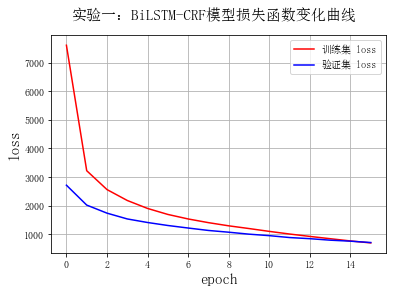

In [23]:
fig, ax = plt.subplots()#创建一个figure 
ax.plot(history.history['loss'], '-r',label='训练集 loss')
ax.plot(history.history['val_loss'], '-b',label='验证集 loss')

####打开网格
ax.grid(True)

####定义x, y轴的名称
ax.set_xlabel('epoch',fontsize=15)
ax.set_ylabel('loss',fontsize=15)

####定义标题
fig.suptitle('实验一：BiLSTM-CRF模型损失函数变化曲线',fontsize=15)

####展示图例 legend loc=是用来定义图例的位置的，还有很多选择，大家可以自己尝试
ax.legend(loc = 'upper right')

plt.savefig("实验一：BiLSTM-CRF模型损失函数变化曲线.png")

In [24]:
history.history['loss']

[7607.94091796875,
 3222.760009765625,
 2563.130126953125,
 2181.842041015625,
 1903.728515625,
 1694.1297607421875,
 1536.3580322265625,
 1407.2509765625,
 1296.3050537109375,
 1201.2607421875,
 1101.86083984375,
 1009.4688720703125,
 925.9458618164062,
 846.2838134765625,
 767.3449096679688,
 699.0057983398438]

In [25]:
history.history['val_loss']

[2716.31201171875,
 2021.2548828125,
 1739.413818359375,
 1536.8348388671875,
 1412.4010009765625,
 1307.8460693359375,
 1219.330078125,
 1134.46533203125,
 1073.1025390625,
 1004.7910766601562,
 952.9447021484375,
 886.5591430664062,
 846.8165283203125,
 794.8212890625,
 759.8312377929688,
 712.3414916992188]

In [26]:
# 保存
model.save("output/BiLSTM_CRF_NER_MODEL")

INFO:tensorflow:Assets written to: output/BiLSTM_CRF_NER_MODEL\assets


INFO:tensorflow:Assets written to: output/BiLSTM_CRF_NER_MODEL\assets


In [27]:
model = models.load_model("output/BiLSTM_CRF_NER_MODEL", compile=False)

In [28]:
import json
with open('output/idx2vocab.json',"w",encoding="utf-8") as f:
    json.dump(idx2vocab,f)
    
with open('output/vocab2idx.json',"w",encoding="utf-8") as f:
    json.dump(vocab2idx,f)

with open('output/idx2label.json',"w",encoding="utf-8") as f:
    json.dump(idx2label,f)

with open('output/label2idx.json',"w",encoding="utf-8") as f:
    json.dump(label2idx,f)

In [29]:
# model = models.load_model("output/bilstm_crf_ner", compile=False)
# 如果需要继续训练，需要下面的重新compile
# model.compile(loss=lambda y_true, y_pred: y_pred, optimizer='adam')

In [30]:
#提取转移矩阵参数
trans_params = model.get_layer('crf').get_weights()[0]
# 获得BiLSTM的输出logits
sub_model = models.Model(inputs=model.get_layer('input_ids').input,
                        outputs=model.get_layer('dense').output)

def predict(model, inputs, input_lens):
    logits = sub_model.predict(inputs)
    # 获取CRF层的转移矩阵
    # crf_decode：viterbi解码获得结果
    pred_seq, viterbi_score = tfa.text.crf_decode(logits, trans_params, input_lens)
    return pred_seq

# 预测

In [31]:
with open('output/idx2vocab.json',encoding="utf-8") as file_obj:
    idx2vocab=json.load(file_obj)
    
with open('output/vocab2idx.json',encoding="utf-8") as file_obj:
    vocab2idx=json.load(file_obj)
    
with open('output/idx2label.json',encoding="utf-8") as file_obj:
    idx2label=json.load(file_obj)
    
with open('output/label2idx.json',encoding="utf-8") as file_obj:
    label2idx=json.load(file_obj)

In [32]:
temp_idx2vocab = {}
for k,v in idx2vocab.items():
    temp_idx2vocab[int(k)] = v
idx2vocab = temp_idx2vocab.copy()

temp_idx2label = {}
for k,v in idx2label.items():
    temp_idx2label[int(k)] = v
idx2label = temp_idx2label.copy()


In [33]:
def pre(X_test,idx2label,model,idx2vocab,vocab2idx):
    result=[]
    maxlen = MAX_LEN
    for item in X_test:
        sentence=''
        for i in item:
            sentence+=idx2vocab[i]
        print(sentence)
        sent_chars = list(sentence)
        sent2id = [vocab2idx[word] if word in vocab2idx else vocab2idx['UNK'] for word in sent_chars]
        sent2id_new = np.array([[0] * (maxlen-len(sent2id)) + sent2id[:maxlen]])
        test_lens = np.array([MAX_LEN])
        pred_seq = predict(model, sent2id_new, test_lens)
        y_label = pred_seq.numpy().reshape(1, -1)[0]
        y_ner = [idx2label[i] for i in y_label][-len(sent_chars):]
        print(y_ner)

In [34]:
#测试集效果检测
test_text = []
for item in X_test:
    sen=''
    for i in item:
        sen+=idx2vocab[i]
    test_text.append(sen)
test_label=[]
for item in y_test:
    test_label.append([idx2label[i] for i in item])

In [35]:
filename='test_text.json'
with open(filename,'w',encoding='gbk') as file_obj:
    json.dump(test_text,file_obj,ensure_ascii=False,indent = 4)
    
filename='test_label.json'
with open(filename,'w',encoding='gbk') as file_obj:
    json.dump(test_label,file_obj,ensure_ascii=False,indent = 4)

In [36]:
def pre_data(sentence,vocab2idx,idx2label):
    maxlen=MAX_LEN
    sent_chars = list(sentence)
    sent2id = [vocab2idx[word] if word in vocab2idx else vocab2idx['UNK'] for word in sent_chars]
    sent2id_new = np.array([[0] * (maxlen-len(sent2id)) + sent2id[:maxlen]])
    test_lens = np.array([MAX_LEN])

    pred_seq = predict(model, sent2id_new, test_lens)
    y_label = pred_seq.numpy().reshape(1, -1)[0]
    y_ner = [idx2label[i] for i in y_label][-len(sent_chars):]
    return y_ner

In [37]:
pre_result=[]
count=0
for sen in test_text:
    #print(sen)
    result=pre_data(sen,vocab2idx,idx2label)
    #print(result)
    pre_result.append(result)
    count+=1
    # print(count)

E:\download\anaconda\download\lib\site-packages\tensorflow_addons\text\crf.py:543: UserWarning: CRF Decoding does not work with KerasTensors in TF2.4. The bug has since been fixed in tensorflow/tensorflow##45534
  warnings.warn(


In [38]:
filename='pre_result.json'
with open(filename,'w',encoding='gbk') as file_obj:
    json.dump(pre_result,file_obj,ensure_ascii=False,indent = 4)

In [39]:
pre_ = []
for s in pre_result:
    for c in s:
        pre_.append(c)
        
test_ = []
for s in y_test:
    for c in s:
        test_.append(idx2label[c])

In [40]:
len(pre_)

3025

In [41]:
len(test_)

3025

In [42]:
pre_[:3]

['B-DRU', 'E-DRU', 'O']

In [43]:
test_[:3]

['B-DRU', 'E-DRU', 'O']

In [53]:
from sklearn.metrics import classification_report
print(classification_report(pre_,test_,digits=4))

              precision    recall  f1-score   support

       B-DRU     0.7906    0.7906    0.7906       191
      B-NAME     0.4722    0.6800    0.5574        25
       B-QUA     0.8636    0.8941    0.8786        85
       B-SYM     0.4608    0.6438    0.5371        73
       B-USE     0.7059    0.7647    0.7341       204
       E-DRU     0.7632    0.8580    0.8078       169
      E-NAME     0.4167    0.9375    0.5769        16
       E-QUA     0.9205    0.9419    0.9310        86
       E-SYM     0.5800    0.7250    0.6444        80
       E-USE     0.6920    0.8031    0.7434       193
       I-DRU     0.2174    0.8333    0.3448         6
      I-NAME     0.9020    0.6389    0.7480        72
       I-QUA     0.3000    0.6667    0.4138         9
       I-SYM     0.5272    0.6467    0.5808       150
       I-USE     0.8185    0.7677    0.7923       693
           O     0.9196    0.7760    0.8417       973

    accuracy                         0.7742      3025
   macro avg     0.6469   

图

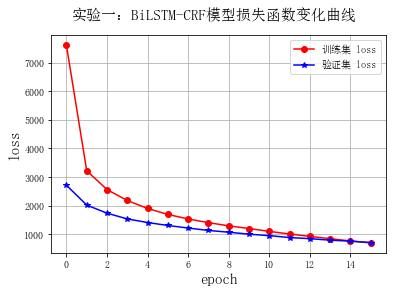

In [54]:
fig, ax = plt.subplots()#创建一个figure 
ax.plot(history.history['loss'], '-r',marker = "o", label='训练集 loss')
ax.plot(history.history['val_loss'], '-b',marker = "*",label='验证集 loss')

####打开网格
ax.grid(True)

####定义x, y轴的名称
ax.set_xlabel('epoch',fontsize=15)
ax.set_ylabel('loss',fontsize=15)

####定义标题
fig.suptitle('实验一：BiLSTM-CRF模型损失函数变化曲线',fontsize=15)

####展示图例 legend loc=是用来定义图例的位置的，还有很多选择，大家可以自己尝试
ax.legend(loc = 'upper right')

plt.savefig("实验一：BiLSTM-CRF模型损失函数变化曲线.png")